# Compute lake area

### 0. Import libraries and load data

In [1]:
import os
import sys
import copy
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

plt.style.use('seaborn-v0_8')

DATA_PATH = "../data/processed/"
GROUND_TRUTH_PATH = "../data/ground_truth/"
GROUND_TRUTH_MONTHLY_PATH = "../data/ground_truth_monthly/"

%matplotlib inline

In [2]:
# load water index maps
water_index_map_names = os.listdir(DATA_PATH)
water_index_map_ =  rasterio.open(DATA_PATH + water_index_map_names[0])
water_index_maps = [rasterio.open(DATA_PATH + name).read(1) for name in water_index_map_names if ".tif" in name]


In [3]:
# load ground truth maps
ground_truth_map_names = os.listdir(GROUND_TRUTH_PATH)
ground_truth_map_ =  rasterio.open(GROUND_TRUTH_PATH + ground_truth_map_names[0])
ground_truth_maps = [rasterio.open(GROUND_TRUTH_PATH + name).read(1) for name in ground_truth_map_names if ".tif" in name]


In [4]:
# load ground truth monthly maps
ground_truth_monthly_map_names = os.listdir(GROUND_TRUTH_MONTHLY_PATH)
ground_truth_monthly_map_ =  rasterio.open(GROUND_TRUTH_MONTHLY_PATH + ground_truth_monthly_map_names[200])
ground_truth_monthly_maps = [rasterio.open(GROUND_TRUTH_MONTHLY_PATH + name).read(1) for name in ground_truth_monthly_map_names if ".tif" in name]


### 1. Analyze the data

In [5]:
def analyze_tif_file(tif_file):
    # compute the distances covered by this map
    latitudinal_distance = tif_file.bounds.right - tif_file.bounds.left
    longitudinal_distance = tif_file.bounds.top - tif_file.bounds.bottom

    # create a list with descriptions of the data properties
    data_descriptions = [
        f"The data has {tif_file.count} band(s).",
        f"The shape of the raster data is {tif_file.height} rows x {tif_file.width} columns.",
        f"The coordinate reference system is {tif_file.crs}. The bounds are relative to the origin of this crs.",
        f"The bounds of the data are: {tif_file.bounds}.",
        f"The map covers a latitudinal distance of {latitudinal_distance} and a longitudinal distance of {longitudinal_distance}.",
    ]

    # concatenate in a string the described data properties and display them
    print("\n".join(data_descriptions))

In [6]:
analyze_tif_file(water_index_map_)

The data has 1 band(s).
The shape of the raster data is 848 rows x 442 columns.
The coordinate reference system is EPSG:32655. The bounds are relative to the origin of this crs.
The bounds of the data are: BoundingBox(left=714555.0, bottom=-3898785.0, right=727815.0, top=-3873345.0).
The map covers a latitudinal distance of 13260.0 and a longitudinal distance of 25440.0.


In [7]:
analyze_tif_file(ground_truth_map_)

The data has 1 band(s).
The shape of the raster data is 840 rows x 515 columns.
The coordinate reference system is EPSG:4326. The bounds are relative to the origin of this crs.
The bounds of the data are: BoundingBox(left=149.3568635781492, bottom=-35.206233626041794, right=149.49565328954566, top=-34.97985817444368).
The map covers a latitudinal distance of 0.13878971139646978 and a longitudinal distance of 0.22637545159811623.


In [8]:
def plot_map(water_index_map, ground_truth_map):
    fig, ax = plt.subplots(1, 3) 
    fig.set_size_inches(10, 5)

    # plot the histogram of pixel-level water index
    ax[0].hist(water_index_map.flatten(), bins=100)
    ax[0].set_xlabel("Water index value")
    ax[0].set_ylabel("Count")
    ax[0].set_title(f"Histogram of the pixel-level water index")

    # plot the water index map
    ax[1].imshow(water_index_map)
    ax[1].set_title("Water index map")
    ax[1].grid(False)

    # plot the ground truth map
    ax[2].imshow(ground_truth_map)
    ax[2].set_title("Ground truth map")
    ax[2].grid(False)

    plt.tight_layout()
    plt.show()

    # compute and display the minimum and maximum elevation values
    min_water_index = str(round(water_index_map.min(), 2))
    max_water_index = str(round(water_index_map.max(), 2))

    print(f"The minimum and maximum values of the water index are {min_water_index} and {max_water_index}.")

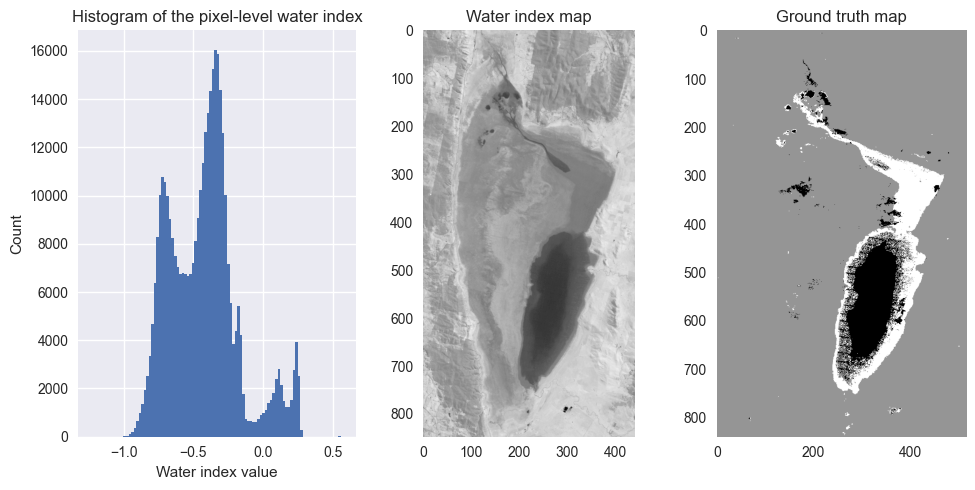

The minimum and maximum values of the water index are -1.24 and 0.57.


In [9]:
# extract the band from the water index
water_index_map = water_index_map_.read(1)

# extract the band from the ground truth
ground_truth_map = ground_truth_map_.read(1)

plot_map(water_index_map, ground_truth_map)

### 2. Detect the lake

In [10]:
"""
create a dictionary for water index and one for ground truth pairs where the year-month is the index
now there can be multiple images per month and we randomly picked one per month
attention - if there are two images with the same year and month, they are concatenated into a numpy array
"""
water_index_months = [file_name[-14:-7] for file_name in water_index_map_names if ".tif" in file_name]
water_index_dataset = {k:v for k,v in sorted(dict(zip(water_index_months, water_index_maps)).items(), key=lambda x:x[0])}

ground_truth_months = [file_name[-14:-7] for file_name in ground_truth_map_names if ".tif" in file_name]
ground_truth_dataset = {k:v for k,v in sorted(dict(zip(ground_truth_months, ground_truth_maps)).items(), key=lambda x:x[0])}

# throw an error these dictionaries don't have the same keys
assert water_index_dataset.keys() == ground_truth_dataset.keys()


In [11]:
def get_min_max_values(water_index_dataset):
    # get the global min and max values of the water index across the dataset
    min_value = sys.maxsize
    max_value = -sys.maxsize

    for water_index in water_index_dataset.values():
        min_value = min(min_value, water_index.flatten().min())
        max_value = max(max_value, water_index.flatten().max())

    return min_value, max_value

In [12]:
def preprocess_ground_truth(ground_truth):
    ground_truth_copy = copy.deepcopy(ground_truth) 
    # replace no data 0 with 1 for not water
    ground_truth_copy[ground_truth_copy == 0] = 1
    # replace water detection 2 with 0 for water
    ground_truth_copy[ground_truth_copy == 2] = 0
    # represent water with 1 and no water with 0
    ground_truth_copy = 1 - ground_truth_copy

    return ground_truth_copy

In [13]:
min_value, max_value = get_min_max_values(water_index_dataset)
# define the space for thresholds
thresholds = np.linspace(min_value, max_value, 100)
accuracies = []

for threshold in thresholds:
    accuracy = 0
    for index, date in enumerate(water_index_dataset.keys()):
        water_detection = water_index_dataset[date][:840, -442:] > threshold
        ground_truth = preprocess_ground_truth(ground_truth_dataset[date][:840, -442:])

        accuracy += (water_detection == ground_truth).sum() / len(ground_truth.flatten())

    accuracies.append(accuracy / len(water_index_dataset))

print(f"The best accuracy is {accuracies}")

The best accuracy is [0.2351824039425227, 0.2351824286524773, 0.2351826757520228, 0.2351832687909321, 0.2351837876999777, 0.2351840100895687, 0.2351844548687507, 0.2351846525483871, 0.2351847760981599, 0.2351848008081145, 0.2351848008081145, 0.2351848008081145, 0.2351847760981599, 0.23518482551806902, 0.23518489964793263, 0.23518489964793263, 0.23518489964793263, 0.23518494906784174, 0.23518497377779632, 0.23518497377779632, 0.23518497377779632, 0.2351849984877509, 0.2351849984877509, 0.2351850231977054, 0.23518507261761457, 0.2351852950072055, 0.2351858386262057, 0.2351872470936152, 0.23519038525784355, 0.23519997272021023, 0.23522606643221874, 0.23529434003664992, 0.23546585183120533, 0.23584302457750933, 0.23662203060476142, 0.23827018457347648, 0.24174917320492065, 0.24922507111524933, 0.26485663778567176, 0.2936903378147307, 0.33575051050766097, 0.3858751722283832, 0.4388307298925213, 0.4907936639722932, 0.5416656782684846, 0.5990846197335675, 0.6687233997339234, 0.740606362516777

In [14]:
threshold_accuracy = pd.DataFrame({"threshold": thresholds, "accuracy": accuracies}).sort_values("accuracy", ascending=False)
threshold_accuracy

,threshold,accuracy
59,0.180026,0.891593
58,0.135943,0.890729
57,0.091859,0.890570
56,0.047776,0.889948
55,0.003692,0.889144
...,...,...
4,-2.244565,0.235184
3,-2.288648,0.235183
2,-2.332732,0.235183
1,-2.376815,0.235182


### 3. Analyze the lake evolution

In [15]:
best_detections = []
best_threshold = threshold_accuracy["threshold"].iloc[0]

for index, date in enumerate(water_index_dataset.keys()):
    best_detections.append(water_index_dataset[date][:840, -442:] > best_threshold)

In [16]:
def display_image(index):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(14, 6)

    date = list(water_index_dataset.keys())[index]

    ax[0].imshow(water_index_dataset[date])
    ax[0].set_title("Water index")
    ax[0].axis("off")

    ax[1].imshow(ground_truth_dataset[date])
    ax[1].set_title("Ground truth")
    ax[1].axis("off")

    try:
        ax[2].imshow(best_detections[index])
        ax[2].set_title("Detection")
        ax[2].axis("off")
    except NameError:
        pass

    fig.suptitle(f"Year-month: {date}")

    plt.show()

interact(display_image, index=widgets.IntSlider(min=0, max=len(water_index_dataset) - 1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='index', max=108), Output()), _dom_classes=('widget-inter…